In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing


## Data Processing

In [6]:
df = pd.read_csv('wildfires(1).txt', delimiter = "\t")
df.dtypes

#to remove unnecessary spaces
df['fire'] = df['fire'].str.replace(" ", "")

df.head()

,fire,year,temp,humidity,rainfall,drought_code,buildup_index,day,month,wind_speed
0,no,2015,28,59,0.0,8.06,3.47,1,6,19
1,no,2010,30,61,1.3,8.17,4.03,2,6,13
2,no,2009,26,83,13.1,8.08,3.59,3,6,22
3,no,2017,25,87,2.5,7.18,2.42,4,6,15
4,no,2014,28,77,0.0,14.98,4.63,5,6,18


## Exploratory Data Analysis

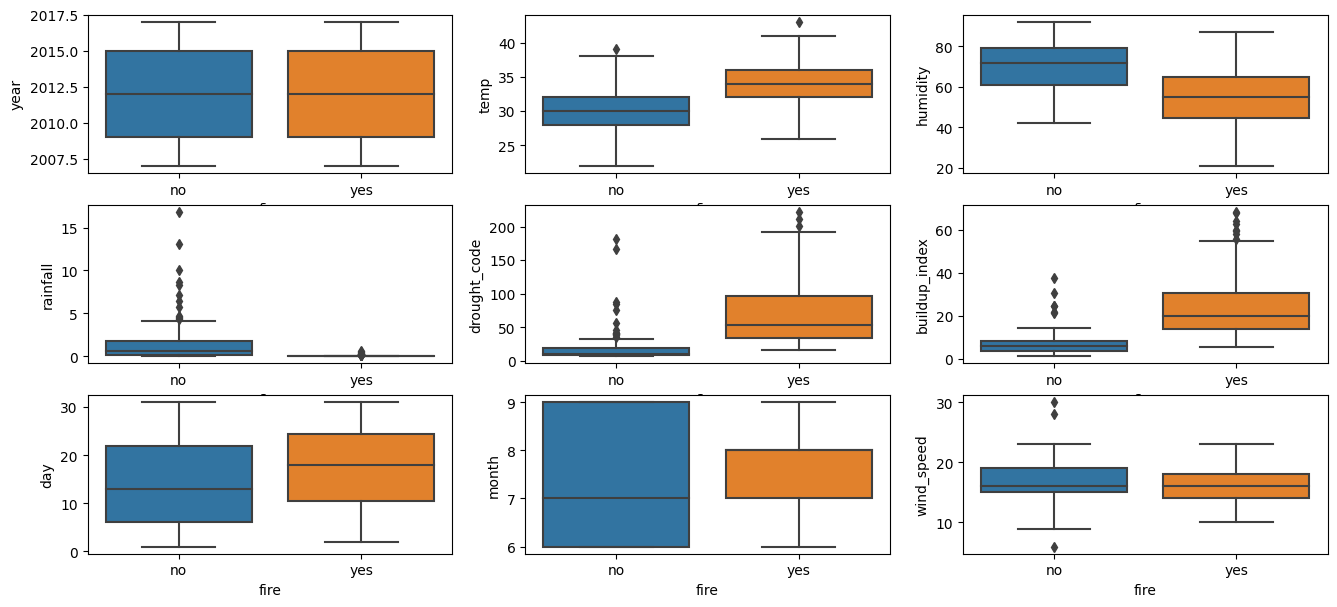

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(16, 7))

for i, col in enumerate(df.columns):
    if col == 'fire': continue

    sns.boxplot(data=df, x='fire', y=col, ax=axes[int((i-1)/3)][(i-1)%3])
    

### Data Cleaning and Normalizing

In [8]:
# cleaning process 


#to encode target
dict_fire = {
    'no' : 0,
    'yes' : 1
}
df['encoded_fire'] = df['fire'].apply(lambda x : dict_fire[x])
ori_df = df.copy()

df = df.drop(['fire'], axis=1)
target = 'encoded_fire'

# normalize data
x = df.drop(['encoded_fire'], axis=1).values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalized = pd.DataFrame(x_scaled, columns=df.drop(['encoded_fire'], axis=1).columns)
df_normalized['encoded_fire'] = df['encoded_fire']
df = df_normalized.copy()

### Checking if the dataset is imbalanced

<AxesSubplot:>

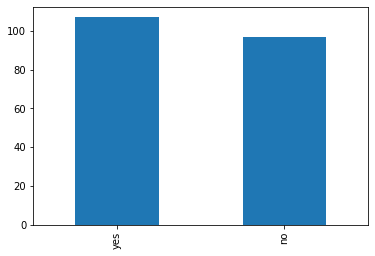

In [50]:
ori_df['fire'].value_counts().plot(kind = 'bar')
#not imbalance

## Split dataset to Train and Test set

In [27]:
# train_test_split
def train_test_split(df):
    test_size = int(len(df)/3)

    size_class_a = int(test_size/2)
    size_class_b = test_size-size_class_a

    #to stratify-split both classes to test set
    test_set_a = df[df[target]==1].sample(n = size_class_a, random_state = 10)
    test_set_b = df[df[target]==0].sample(n = size_class_b, random_state = 10)
    test_set = pd.concat([test_set_a, test_set_b], axis=0)#.reset_index(drop=True)

    train_set = df[~df.index.isin(test_set.index.values)]#.reset_index(drop=True)
    
    return train_set, test_set

train_set, test_set = train_test_split(df)
#print(train_test_split(df))


## Split Training set to K-fold for Cross Validation

In [42]:
def cross_validation_split(df, split=5):
    fold_size = int(len(df)/split)
    foldsize_class_a = int(fold_size/2)
    foldsize_class_b = fold_size-foldsize_class_a

    kfold_split = []
    for i in range(split):
#         print(i)
        if i == split-1:
            kfold_split.append(df)
            return kfold_split
        
        #to stratify-split both classes to test set
        foldtest_set_a = df[df[target]==1].sample(n = foldsize_class_a, random_state = 10)
        foldtest_set_b = df[df[target]==0].sample(n = foldsize_class_b, random_state = 10)
        foldtest_set = pd.concat([foldtest_set_a, foldtest_set_b], axis=0)
#         print(foldtest_set)
        df = df[~df.index.isin(foldtest_set.index.values)] # remove the test fold from df

        # train_set = df[~df.index.isin(test_set.index.values)]
        kfold_split.append(foldtest_set)
                
dfs = cross_validation_split(train_set, 5)


## Hardcode MultilayerPerceptron (fix 2 hidden layers)

## Custom Multilayer Perceptron Model

with this model, user is able to define their desire:
- epoch
- learning rate
- threshold
- the number of hidden layers and the respective neuron in each layer

In [47]:
layer=[4,4]
layer.insert(0, 9) #add input layer
layer.append(1) #add output layer

print(len(layer))

4


In [82]:
class CustomMLP:
    def __init__(self, X_train, y_train, epoch=5, lr=1e-5, threshold=0.5, layer=[4,4]):
        '''
        lr: learning rate
        threshold: to get the final class
        layer: len(layer) <- number of hidden layers while element in layer indicates the number of neurons in each layer
        X_train: features of training data
        y_train: label of training data
        '''
        np.random.seed(10)
        
        self.Weights = []
        self.Biases = []
        
        self.FF_Output = []
        self.BP_Error = []
        
        self.loss = []
        self.acc = []
        
        self.X = X_train
        self.y = y_train
        
        self.lr = lr
        self.epoch = epoch
        self.threshold = threshold
        
        self.pred = []
        
        layer.insert(0, X_train.shape[1]) #add input layer
        layer.append(1) #add output layer
        for i in range(1, len(layer)):
            if i == len(layer)-1:
                #xavier for sigmoid
                self.Weights.append(np.random.randn(layer[i-1]) * np.sqrt(1/layer[i-1]))
            else:
                #he for relu
                self.Weights.append(np.random.randn(layer[i], layer[i-1]) * np.sqrt(2/layer[i-1]))
            self.Biases.append(np.random.rand(layer[i]))
            
        self.hiddenLayer = layer[1:-1]
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def deriv_sigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def relu(self, x):
        return np.maximum(0, x) #>0, x; <0, 0

    def deriv_relu(self, x):
        return np.heaviside(1, x) #>=0, 1; <0, 0
    
    def feedforward(self, x):
        self.FF_Output = []
        
        self.FF_Output.append(self.relu(np.dot(self.Weights[0], x) + self.Biases[0]))
        
        for i in range(1, len(self.hiddenLayer)):                                
            self.FF_Output.append(self.relu(np.dot(self.Weights[i], self.FF_Output[i-1]) + self.Biases[i]))
         
        self.FF_Output.append(self.sigmoid(np.dot(self.Weights[len(self.FF_Output)], self.FF_Output[-1]) + self.Biases[len(self.FF_Output)]))
        
        
    def backpropagation_error(self, y):
        #start from last to first layer
        self.BP_Error = []
        
        z = self.FF_Output
        self.BP_Error.append((z[-1] - y) * self.deriv_sigmoid(z[-1]))
        
        self.BP_Error.append(self.BP_Error[0][0]*self.Weights[-1] * self.deriv_relu(z[-2]))
        
        for i in range(1, len(z)-1): 
            self.BP_Error.append(np.dot(self.BP_Error[i], self.Weights[len(z)-1-i]) * self.deriv_relu(z[len(z)-2-i]))

        #flip to [first layer, last layer]
        self.BP_Error = np.flip(self.BP_Error, 0)
                        
    def gradient_descent(self, x):
        self.Weights[0] -= self.lr * np.kron(self.BP_Error[0], x).reshape(self.hiddenLayer[0], self.X.shape[1])
        self.Biases[0] -= self.lr * self.BP_Error[0]
        
        for i in range(1, len(self.Weights)-1):
            self.Weights[i] -= self.lr * np.kron(self.BP_Error[i], self.FF_Output[i-1]).reshape(self.hiddenLayer[i], self.hiddenLayer[i-1])
            self.Biases[i] -= self.lr * self.BP_Error[i]
 
        self.Weights[-1] -= self.lr * np.kron(self.BP_Error[-1], self.FF_Output[-2]).reshape(self.hiddenLayer[-1])
        self.Biases[-1] -= self.lr * self.BP_Error[-1]

    def Fit(self):
        for e in range(self.epoch):
            self.loss = []
            
            for i in range(len(self.X)):
                self.feedforward(self.X[i])
                
                self.loss.append((self.FF_Output[-1] - self.y[i]) ** 2)

                self.backpropagation_error(self.y[i])
                self.gradient_descent(self.X[i])
    #             break
    
    
    def Predict(self, X_test):
        pred = []
        
        for i in range(len(X_test)):
            self.feedforward(X_test[i])
            
            pred.append(1 if self.FF_Output[-1] >= self.threshold else 0)
            
            accuracy = pred[i]
            
        return pred
    
    def getAccuracy(self, pred, actual):
        total = 0
        actual = list(actual)
        for i in range(len(actual)):
            if pred[i] == actual[i]:
                total += 1
                
        return total/len(actual)

## To save the training and prediction output

In [86]:
def saveOutputAsTxt(train_set, test_set, model, test_pred, lossFileName = 'loss.txt', predFileName = 'results.txt'):

    ori_train = ori_df[ori_df.index.isin(train_set.index.values)].reindex(train_set.index)
    ori_test = ori_df[ori_df.index.isin(test_set.index.values)].reindex(test_set.index)

    ori_test['pred'] = test_pred
    ori_train['loss'] = [loss[0] for loss in model.loss]

    ori_train.to_csv(lossFileName, sep='\t', index=False)
    print(f"successfully saved as {lossFileName}")
    
    ori_test.to_csv(predFileName, sep='\t', index=False)
    print(f"successfully saved as {predFileName}")

## To use the custom model

*CustomMLP(X_train, y_train, epoch=10, lr=1e-5, threshold=0.5, layer=[2,6])*

the code above is used to create the model by setting the following arguments:
- features (X_train)
- label (y_train)
- epoch (default to 5)
- learning rate (default to 1e-5)
- threshold (default to 0.5)
- layer (default to 2 hidden layers with 4 neurons in each layer)

*model.Fit() <- is to train the data*

*model.Predict(X_test) <- is to predict your data with the weights learnt in Fit()*

*model.getAccuracy(model.Predict(X_test), y_test) <- is to show the accuracy of the model*


In [87]:

def crossValidation(dataset):
    
    for k, ktest in enumerate(dataset):

        ktrain = train_set[~train_set.index.isin(ktest.index.values)]
        ktest = ktest.sample(frac=1, random_state = 10)
        
        X_train, X_test = ktrain.drop(target, axis=1).to_numpy(), ktest.drop(target, axis=1).to_numpy()
        y_train, y_test = ktrain[target].to_numpy(), ktest[target].to_numpy()
        model = CustomMLP(X_train, y_train, epoch=10, threshold=0.5, layer=[2,6]) 
        model.Fit()

        train_pred = model.Predict(X_train)
        test_pred = model.Predict(X_test)

        print(f"""@ Fold{k+1}: loss = {np.mean(model.loss)}
            test accuracy = {model.getAccuracy(test_pred, y_test)}
            """)
    #     break
    
    
crossValidation(dfs)

test_set = test_set.sample(frac=1, random_state = 10)
X_train, X_test = train_set.drop(target, axis=1).to_numpy(), test_set.drop(target, axis=1).to_numpy()
y_train, y_test = train_set[target].to_numpy(), test_set[target].to_numpy()
model = CustomMLP(X_train, y_train, epoch=10, threshold=0.5, layer=[2,6]) 
model.Fit()

# train_pred = model.Predict(X_train)
test_pred = model.Predict(X_test)

# train accuracy = {model.getAccuracy(train_pred, y_train)}

print(f"""Final Training @ loss = {np.mean(model.loss)}
            test accuracy = {model.getAccuracy(test_pred, y_test)}
            """)

saveOutputAsTxt(train_set, test_set, model, test_pred)


@ Fold1: loss = 0.24655052786898504
            test accuracy = 0.48148148148148145
            
@ Fold2: loss = 0.24819887152052494
            test accuracy = 0.48148148148148145
            
@ Fold3: loss = 0.24760693386859295
            test accuracy = 0.48148148148148145
            
@ Fold4: loss = 0.2475978230232765
            test accuracy = 0.48148148148148145
            
@ Fold5: loss = 0.26919501277810687
            test accuracy = 0.75
            
Final Training @ loss = 0.25173772247981624
            test accuracy = 0.5
            
successfully saved as loss.txt
successfully saved as results.txt


## MLP Classifier from SkLearn

In [ ]:
from sklearn.neural_network import MLPClassifier

test_set = test_set.sample(frac=1, random_state = 10)
X_train, X_test = train_set.drop(target, axis=1).to_numpy(), test_set.drop(target, axis=1).to_numpy()
y_train, y_test = train_set[target].to_numpy(), test_set[target].to_numpy()

clf = MLPClassifier(hidden_layer_sizes=(2, 6), random_state=10, solver='sgd', batch_size=1, learning_rate_init=1e-5)
clf.fit(X_train, y_train)
clf.predict(X_test[:, :])